# Hyperparameter Optimization

Hyperparameters refer to those parameters used in training. Given that the optimization algorithms in a Neural Network such as `SGD` and `Adam` are stochastic in nature, it also means that a DNN trained with different hyperparameters might have different solutions (landing in a different local minima).

Finding the best parameters possible for training our neural network is what we call `hyperparameter optimization`.

One could just simply try different variations of hyperparameters manually. Fortunately, there are better ways of doing this. In this lesson, we will be using Pytorch to create our neural network and sklearn modules `sklearn.model_selection.GridSearchCV` and `sklearn.model_selection.RandomizedSearchCV` for the hyperparameter optimization.

# Import Libraries

In [1]:
import numpy as np
import torch
import torchvision
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from torchvision import transforms as T

import itertools
from tqdm.auto import tqdm

torch.backends.cudnn.enabled = False
torch.manual_seed(2020)

In [2]:
# setting device on GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device == "cuda":
    print("Name device:", torch.cuda.get_device_name(0))

Using device: cuda


# Data Transforms

Now we will create a pipeline of data transformations.

For the train
- We transform an Image to a Pytorch tensor
- Normalize data using only one channel (gray scale image)

In [3]:
batch_size = 64

In [4]:
data_transforms = {
    # For the data training dataset
    "train": T.Compose([T.ToTensor(), T.Normalize((0.0,), (1.0,))]),
    # For the validation dataset
    "val": T.Compose([T.ToTensor(), T.Normalize((0.0,), (1.0,))]),
}

Let's create a data loader for the training and testing dataset. `MNIST` is a dataset that contains images of handwritten digits from 0 to 9. We will train a classifier using hyperparameter optimization.

In [5]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "../../data/processed/MNIST", train=True, download=False, transform=data_transforms["train"]
    ),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "../../data/processed/MNIST", train=False, download=False, transform=data_transforms["val"]
    ),
    batch_size=batch_size + 64,
    shuffle=True,
)

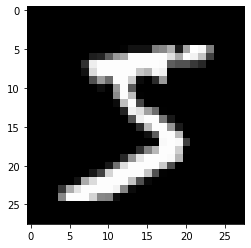

In [6]:
plt.imshow(train_loader.dataset[0][0][0], cmap='gray')

# GridSearchCV

`GridSearch` tries all possible combinations over specified parameter values for the model. We will implement a Grid Search method from scratch that allow us to try different parameters in our model and pick the best ones for training.



But first, let's create a CNN model. We will start by creating a function that returns a block of layers given some parameters.

In [7]:
def create_block(input_dim, output_dim, kernel, padding, activation="relu"):
    activations = {
        "relu": nn.ReLU(inplace=True),
        "tanh": nn.Tanh(),
        "selu": nn.SELU(inplace=True),
        "sigmoid": nn.Sigmoid(),
    }
    return nn.Sequential(
        nn.Conv2d(
            in_channels=input_dim,
            out_channels=output_dim,
            kernel_size=kernel,
            padding=padding,
        ),
        nn.BatchNorm2d(output_dim),
        activations[activation],
        nn.MaxPool2d(2),
    )

Now let's create the architecture of our model.

In [8]:
class MNISTCNN(nn.Module):
    def __init__(self, activation):
        super(MNISTCNN, self).__init__()

        self.layer1 = create_block(1, 32, 3, 1, activation)
        self.layer2 = create_block(32, 64, 3, 1, activation)
        self.layer3 = create_block(64, 128, 3, 1, activation)
        self.fc1 = nn.Linear(in_features=128 * 3 * 3, out_features=256)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

Now let's create a typical function for the training process in Pytorch:

In [9]:
def train(model, dataloader, criterion, optimizer, n_epochs=1, bs=64, device="cpu"):
    # Set model in train mode
    model.train().to(device)
    for epoch in tqdm(range(n_epochs), desc='train', unit='epoch'):
        for (x, y) in tqdm(dataloader, leave=False, desc='training'):
            y = y.to(device)
            x = x.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(x)  # Get the prediction here
            loss = criterion(outputs, y)  # Calculate loss
            loss.backward()  # Do backpropagation
            optimizer.step()  # Update weights

    print("Finished Training")
    return model.eval()

In [10]:
def evaluation(model, dataloader, device="cpu"):
    print("Evaluation...")
    total = 0
    correct = 0
    model = model.eval().to(device)

    for (x, y) in tqdm(dataloader, desc='testing', leave=False):

        y = y.to(device)
        x = x.to(device)
        # Make prediction
        pred = model(x).argmax(1)

        # Count correct answers
        correct += int(sum(y == pred))
        # Count total number of images
        total += pred.shape[0]

    # Return accuracy metric
    return correct / total

Now let's create a method that allow us to try different parameters such as the number of `epochs`, the `optimizer`, and the `activation functions` used.

In [11]:
# Get a criterion given a name
def get_criterion(criterion_name):
    criterions = {
        "cross_entropy": nn.CrossEntropyLoss()
        # You can add more criterions here if you need to
    }

    return criterions[criterion_name]


# Get an optimizer given a name, model and learning rate
def get_optimizer(optimizer_name, model, learning_rate=1e-3):
    optimizers = {
        "sgd": optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9),
        "adam": optim.Adam(model.parameters(), lr=learning_rate),
        "adagrad": optim.Adagrad(model.parameters(), lr=learning_rate),
    }

    return optimizers[optimizer_name]


def GridSearch(train_data, test_data, hyperparameters):
    best_accuracy = 0
    best_parameters = {
        "epoch": 0,
        "activation": None,
        "optimizer": None,
        "learning_rate": 0.0,
    }
    
    possible_values = list(itertools.product(*hyperparameters.values()))
    
    for values in tqdm(possible_values, desc='gridsearch'):
        hparams = dict(zip(hyperparameters.keys(), values))
        
        activation = hparams['activations']
        epochs = hparams['epochs']
        epochs = hparams['epochs']
        opt = hparams['optimizers']
        learning_rate = hparams['learning_rate']

        model = MNISTCNN(activation).to(device)
        criterion = get_criterion("cross_entropy")
        optimizer = get_optimizer(opt, model, learning_rate)
        print(
            'Training NN...optimizer:{}, activation:{}, epochs:{}, learning rate:{}'.format(opt, activation, epochs, learning_rate)
        )
        # Let's train the model using our custom hyperparameters
        clf = train(
            model,
            train_data,
            criterion,
            optimizer,
            n_epochs=epochs,
            bs=64,
            device=device,
        )
        accuracy = evaluation(clf, test_data, device)

        if accuracy > best_accuracy:
            # Update parameters
            best_accuracy = accuracy
            best_parameters["epoch"] = epochs
            best_parameters["activation"] = activation
            best_parameters["optimizer"] = opt
            best_parameters["learning_rate"] = learning_rate

        print('Accuracy Testing: {}'.format(accuracy))
        print('best_parameters', best_parameters)
    return best_parameters

<div class="alert alert-success" style="font-size:100%">
<b>Exercise 1</b>: <br>
    
**Warning:** GridSearch performs an exhaustive search with the parameters given. It might take around 12 minutes to complete the optimization in a GPU for the hyperparameters given below.
    
1. Pass the following hyperparameters to the function `GridSearch`.
    
```python
hyperparameters = {
    'epochs': [1],
    'activations': ['selu','tanh','relu'],
    'optimizers': ['adagrad','sgd','adam'],
    'learning_rate': [1e-2, 1e-3]
}
```
2. Execute the function and find the best hyperparameter for training.
    
Note it may take 15 minutes on a GPU
</div>

You can click in the button below the reveal the solution for exercise 1

<details>    
<summary>
    <font size="4" color="darkblue"><b>See the solution for Exercise 1</b></font>
</summary>
    
```python
hyperparameters = {
    'epochs': [1],
    'activations': ['selu','tanh','relu'],
    'optimizers': ['adagrad','sgd','adam'],
    'learning_rate': [1e-2, 1e-3]
}

import time
# This line of code is to measure the executation time
start_time = time.time()
######################################################
# YOU CODE GOES HERE
best_params = GridSearch(train_loader, test_loader, hyperparameters)
print(best_params)
######################################################
print(f'--- {(time.time() - start_time)/60.0} minutes ---')
```

    
You should get this as a result:
    
```python
{'epoch': 1,
 'activation': 'relu',
 'optimizer': 'sgd',
 'learning_rate': 0.001} 
```
</details>

# Randomized Grid Search

As you can notice, GridSearch evaluates the model in combining every parameter. This of course, can be very inneficient. By contrast, Random Search sets up a grid of hyperparameter values and selects random combinations to train the model and evaluate. In random search you can control the number of hyperparameter combinations that attempted. It is possible that Random search does not find the best possible answer but in cases where the search space and computational time is limited it will work the best.

In [12]:
def RandomizedGridSearch(train_data, test_data, hyperparameters, num_combinations=5):
    best_accuracy = 0
    best_parameters = {
        "epoch": 0,
        "activation": None,
        "optimizer": None,
        "learning_rate": 0.0,
    }

    # Try different combinations
    for i in tqdm(range(num_combinations), desc='RandomizedGridSearch'):
        # Pick random hyperparameters
        activation = np.random.choice(hyperparameters["activations"])
        model = MNISTCNN(activation).to(device)
        epochs = np.random.choice(hyperparameters["epochs"])
        opt = np.random.choice(hyperparameters["optimizers"])
        l_rate = np.random.choice(hyperparameters["learning_rate"])

        # Select criterion and optimizer
        criterion = get_criterion("cross_entropy")
        optimizer = get_optimizer(opt, model, l_rate)

        print(
            'Training NN...optimizer:{}, activation:{}, epochs:{}, learning rate:{}'.format(opt, activation, epochs, l_rate)
        )
        # Let's train the model using our custom hyperparameters
        clf = train(
            model,
            train_data,
            criterion,
            optimizer,
            n_epochs=epochs,
            bs=64,
            device=device,
        )
        # Evaluate
        accuracy = evaluation(clf, test_data, device)

        if accuracy > best_accuracy:
            # Update parameters
            best_accuracy = accuracy
            best_parameters["epoch"] = epochs
            best_parameters["activation"] = activation
            best_parameters["optimizer"] = opt
            best_parameters["learning_rate"] = l_rate

        print('Accuracy Testing: {}'.format(accuracy))
        print('best_parameters', best_parameters)

    return best_parameters

In the next exercise we will increase the parameter space search but will limit to a number of 10 random searches.

<div class="alert alert-success" style="font-size:100%">
<b>Exercise 2</b>: <br>
    
**Warning:** Executing `RandomizedGridSearch` might take around 5 minutes on a GPU.
    
1. Pass the following hyperparameters to the function `RandomizedGridSearch`.
    
```python
hyperparameters = {
    'epochs': [1],
    'activations': ['sigmoid','selu','tanh','relu'],
    'optimizers': ['adagrad','sgd','adam'],
    'learning_rate': [1e-2, 1e-3, 1e-4]
}
```

**NOTE:** If we were going to pass the same hyperparameter space to a `GridSearch` algorithm it would perform 108 combinations. This would take significantly more time.
    
2. Execute the function and find the best hyperparameter for training. Limit the random searches to 5.
3. Measure the executation time of the code in minutes. **Hint:** Check solution for exercise 1.
    
Note it may take 5 minutes on a GPU
</div>

You can click in the button below the reveal the solution for exercise 2

<details>    
<summary>
    <font size="4" color="darkblue"><b>See the solution for Exercise 2</b></font>
</summary>
    
```python
hyperparameters = {
    'epochs': [1],
    'activations': ['sigmoid','selu','tanh','relu'],
    'optimizers': ['adagrad','sgd','adam'],
    'learning_rate': [1e-2, 1e-3, 1e-4]
}

# This line of code is to measure the executation time
start_time = time.time()
######################################################
# YOU CODE GOES HERE
best_params = RandomizedGridSearch(train_loader, test_loader, hyperparameters, num_combinations=5)
print(best_params)
######################################################
print(f'--- {(time.time() - start_time)/60.0} minutes ---')
```

    
Given the stochastic nature of the approach you might get different results everytime you execute this.
</details>

# More meta

- You can you bayesian priors sample well, and reduce the search time https://scikit-optimize.github.io/stable/
- You can machine learn the machine learning, of popular example is [MAML](https://arxiv.org/abs/1703.03400)

# Auto:Test

Ignore the below, it's for automatic testing

In [13]:
hyperparameters = {
    'epochs': [1],
    'activations': ['selu'],
    'optimizers': ['adagrad'],
    'learning_rate': [1e-2]
}

import time
# This line of code is to measure the executation time
start_time = time.time()
######################################################
# YOU CODE GOES HERE
best_params = GridSearch(train_loader, test_loader, hyperparameters)
print('best_params', best_params)
######################################################
print(f'--- {(time.time() - start_time)/60.0} minutes ---')

Training NN...optimizer:adagrad, activation:selu, epochs:1, learning rate:0.01



Finished Training
Evaluation...


Accuracy Testing: 0.9816
best_parameters {'epoch': 1, 'activation': 'selu', 'optimizer': 'adagrad', 'learning_rate': 0.01}

best_params {'epoch': 1, 'activation': 'selu', 'optimizer': 'adagrad', 'learning_rate': 0.01}
--- 0.6379638552665711 minutes ---


In [14]:
hyperparameters = {
    'epochs': [1],
    'activations': ['sigmoid','selu','tanh','relu'],
    'optimizers': ['adagrad','sgd','adam'],
    'learning_rate': [1e-2, 1e-3, 1e-4]
}

# This line of code is to measure the executation time
start_time = time.time()
######################################################
# YOU CODE GOES HERE
best_params = RandomizedGridSearch(train_loader, test_loader, hyperparameters, num_combinations=1)
print(best_params)
######################################################
print(f'--- {(time.time() - start_time)/60.0} minutes ---')

Training NN...optimizer:adagrad, activation:sigmoid, epochs:1, learning rate:0.01



Finished Training
Evaluation...


Accuracy Testing: 0.8444
best_parameters {'epoch': 1, 'activation': 'sigmoid', 'optimizer': 'adagrad', 'learning_rate': 0.01}

{'epoch': 1, 'activation': 'sigmoid', 'optimizer': 'adagrad', 'learning_rate': 0.01}
--- 0.6128351330757141 minutes ---
